# Ondes de Rossby des moyennes latitudes/diagrammes de Hovmöller 

**Auteur : FERRY Frédéric (DESR/ENM/C3M) - novembre 2021**

Dans l'atmosphère des moyennes latitudes, les **ondes de Rossby désignent les oscillations (alternance de thalwegs et de dorsales) dans la circulation générale d’ouest**. Ces oscillations doivent leur nom au physicien suédois Carl Gustaf Arvid Rossby, qui est le premier à les avoir étudiées en 1939 grâce au modèle barotrope non-divergent. Dans ce modèle théorique, une particule déplacée de sa latitude d'origine oscille autour d'une latitude de référence sous la contrainte de conservation du tourbillon absolu, mécanisme de rappel donnant ainsi naissance aux ondes de Rossby.

D'après les solutions théoriques du modèle barotrope non divergent, la **vitesse de phase zonale des ondes de Rossby est dirigée vers l’ouest par rapport à l'écoulement de base d’ouest des moyennes latitudes**. Ainsi, il existe un **mode stationnaire de longueur d'onde théorique d'environ 5000-7000km** qui sépare les modes se **propageant vers l'est (ondes courtes d'échelle synoptique)** des modes **se propageant vers l'ouest (ondes longues d'échelle planétaire)**. Les ondes Rossby sont dispersives : l'énergie d'un paquet d'onde de Rossby se propage à une vitesse de groupe zonale supérieure à la vitesse de phase zonale (**propagation aval**).

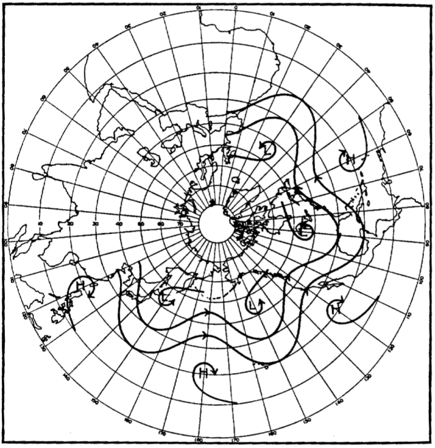

L'objectif de ce TP Python est d’étudier les caractéristiques de propagation des ondes Rossby des moyennes latitudes à travers l'**analyse de cartes, d'animations et la réalisation de diagrammes temps-longitude (diagrammes de Hovmöller)**.

On exploitera des champs quotidiens de **géopotentiel à 500hPa et de vent méridien à 300hPa**. On cherchera à mettre en évidence la propagation de paquets d’ondes de Rossby (Rossby Wave Packets, RWP) caractérisés par un nombre fini de thalwegs/dorsales confinés zonalement dans une région limitée du globe. On recherchera des situations où le flux méridien d’altitude s’intensifie (en lien avec des mécanismes de propagation aval de l’énergie des ondes de Rossby) conduisant souvent à des évènements extrêmes en aval (épisodes neigeux en hiver, précipitations intenses et évènements Méditerranéens en automne). On s'intéressera également à des situations estivales pouvant être caractérisées par la persistence d'un mode quasi-stationnaire souvent en lien avec des évènements extrêmes (vagues de chaleur, innondations).

Concepts Python illustrés :

- Exploitation de fichiers de données quotidiennes au format netcdf (module xarray)
- Calcul de climatologies (via xarray)
- Calcul d'anomalies quotidiennes (via la méthode groupby de xarray)
- Tracé de séries temporelles ponctuelles
- Tracé de cartes et d'animations (matplotlib/cartopy)
- Tracé de diagrammes temps-longitude (diagrammes de Hovmöller)

<div class="alert alert-warning">
<b>Instructions : </b>
<p><b>1) </b>Exécuter les cellules qui suivent de façon séquentielle</p>
<p><b>2) </b>Répondre aux questions (cadres de couleur jaune) dans les parties dédiées (cadres de couleur verte)</p>
<p><b>3) </b>Sauvegarder le notebook final au format pdf</p>
</div>

In [ ]:
%matplotlib inline

import os

import xarray as xr
import numpy as np

from cartopy.util import add_cyclic_point
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.path as mpath

import IPython.display as IPdisplay, matplotlib.font_manager as fm
from PIL import Image
import glob

In [ ]:
dir_data='./data/'
dir_figs='./figs/'
dir_anim='./anim/'
if not os.path.exists(dir_figs):
    os.makedirs(dir_figs)
if not os.path.exists(dir_anim):
    os.makedirs(dir_anim)

# Climatologies des variables de géopotentiel à 500hPa et de vent méridien à 300hPa

In [ ]:
year1='1980'
year2='2020'

fz    = xr.open_dataset(dir_data+'hgt500.1979-2021.nc').sel(time=slice(year1,year2))
fv    = xr.open_dataset(dir_data+'vwnd300.1979-2021.nc').sel(time=slice(year1,year2))

print(fz)
print(fv)

In [ ]:
fz_mean = fz.groupby('time.season').mean('time')
fz_zmean = fz_mean.mean('lon')
fv_mean = fv.groupby('time.season').mean('time')

seasons=['DJF','JJA','MAM','SON']

dataz, dataz_zmean, = xr.broadcast(fz_mean['hgt'],fz_zmean['hgt'])
dataz_anom=dataz-dataz_zmean
datav = fv_mean['vwnd']

lat  = dataz.lat.values

In [ ]:
def lonflip(da):
    lon_name = 'lon'
    da['_longitude_adjusted'] = xr.where(
        da[lon_name] > 180,
        da[lon_name] - 360,
        da[lon_name])
    da = (
        da
        .swap_dims({lon_name: '_longitude_adjusted'})
        .sel(**{'_longitude_adjusted': sorted(da._longitude_adjusted)})
        .drop(lon_name))
    da = da.rename({'_longitude_adjusted': lon_name})
    return da

In [ ]:
dataz = lonflip(dataz)
dataz_anom = lonflip(dataz_anom)
datav = lonflip(datav)

In [ ]:
print("Original shape -", dataz.shape)
lon0 = dataz.coords['lon']
lon_idx = dataz.dims.index('lon')
dataz, lon = add_cyclic_point(dataz.values, coord=lon0, axis=lon_idx)
dataz_anom, lon = add_cyclic_point(dataz_anom.values, coord=lon0, axis=lon_idx)
datav, lon = add_cyclic_point(datav.values, coord=lon0, axis=lon_idx)
print("New shape -", dataz.shape)

In [ ]:
levels_z = np.arange(5000,6050,50)
cmap_z='jet'
levels_zanom = np.arange(-200,220,20)
cmap_zanom='RdBu_r'
levels_v = np.arange(-15,17.5,2.5)
cmap_v='RdBu_r'

In [ ]:
def plot_background0(ax):
    ax.coastlines()
    ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.5, color='gray', alpha=0.5, linestyle='-')
    angle = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(angle), np.cos(angle)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    return ax

In [ ]:
bounds = [(-180., 180., 30, 90)]

axes_class = (GeoAxes, dict(map_projection=ccrs.NorthPolarStereo()))

fig = plt.figure(figsize=(15, 15))
fig.suptitle('Geopotential height at 500 hPa (mgp) : '+year1+'-'+year2, fontsize=16)

axgr = AxesGrid(fig, 111, axes_class=axes_class,
       nrows_ncols=(2, 2),
       axes_pad=0.6,
       cbar_location='right',
       cbar_mode='single',
       cbar_pad=0.2,
       cbar_size='6%',
       label_mode='')  # note the empty label_mode
       
for i, ax in enumerate(axgr):
    plot_background0(ax)
    ax.set_extent(*bounds, crs=ccrs.PlateCarree())
    ax.set_title(seasons[i], fontsize=14)
    cf = ax.contourf(lon, lat, dataz[i,:,:], levels_z, transform=ccrs.PlateCarree(), cmap=cmap_z, extend='both')
    c = ax.contour(lon, lat, dataz[i,:,:], levels_z, colors='black', linewidths=1)
    plt.colorbar(cf, cax=axgr.cbar_axes[0])

plt.show()

figname=dir_figs+'z500_HN_climatology'
fig.savefig(figname+'.png', bbox_inches='tight')

In [ ]:
axes_class = (GeoAxes, dict(map_projection=ccrs.NorthPolarStereo()))

fig = plt.figure(figsize=(15, 15))
fig.suptitle('Geopotential height at 500 hPa anomaly from zonal mean (mgp) : '+year1+'-'+year2, fontsize=16)

axgr = AxesGrid(fig, 111, axes_class=axes_class,
       nrows_ncols=(2, 2),
       axes_pad=0.6,
       cbar_location='right',
       cbar_mode='single',
       cbar_pad=0.2,
       cbar_size='6%',
       label_mode='')  # note the empty label_mode
       
for i, ax in enumerate(axgr):
    plot_background0(ax)
    ax.set_extent(*bounds, crs=ccrs.PlateCarree())
    ax.set_title(seasons[i], fontsize=14)
    cf = ax.contourf(lon, lat, dataz_anom[i,:,:], levels_zanom, transform=ccrs.PlateCarree(),
                     cmap=cmap_zanom, extend='both')
    c = ax.contour(lon, lat, dataz_anom[i,:,:], levels_zanom, colors='black', linewidths=1)
    plt.colorbar(cf, cax=axgr.cbar_axes[0])

plt.show()

figname=dir_figs+'z500_anom_HN_climatology'
fig.savefig(figname+'.png', bbox_inches='tight')

<div class="alert alert-warning">
<b>Questions : </b>
<p><b>1) </b>Situer les thalwegs et dorsales climatologiques aux moyennes latitudes dans l'hémisphère nord. Combien de maximaums/minimum compte-t-on sur un cercle de latitude aux moyennes latitudes (i.e. nombre d'onde zonal du mode climatologique stationnaire observé) ?</p>
<p><b>2) </b>En quelle saison l'amplitude de ces ondes stationnaires est-elle la plus importante ?</p>
</div>

<div class="alert alert-success">
<b>Réponses : </b>
</div>

In [ ]:
axes_class = (GeoAxes, dict(map_projection=ccrs.NorthPolarStereo()))

fig = plt.figure(figsize=(15, 15))
fig.suptitle('Meridional wind at 300 hPa (m/s) : '+year1+'-'+year2, fontsize=16)

axgr = AxesGrid(fig, 111, axes_class=axes_class,
       nrows_ncols=(2, 2),
       axes_pad=0.6,
       cbar_location='right',
       cbar_mode='single',
       cbar_pad=0.2,
       cbar_size='6%',
       label_mode='')  # note the empty label_mode
       
for i, ax in enumerate(axgr):
    plot_background0(ax)
    ax.set_extent(*bounds, crs=ccrs.PlateCarree())
    ax.set_title(seasons[i], fontsize=14)
    cf = ax.contourf(lon, lat, datav[i,:,:], levels_v, transform=ccrs.PlateCarree(), cmap=cmap_v, extend='both')
    c = ax.contour(lon, lat, datav[i,:,:], levels_v, colors='black', linewidths=1)
    plt.colorbar(cf, cax=axgr.cbar_axes[0])

plt.show()

figname=dir_figs+'v300_HN_climatology'
fig.savefig(figname+'.png', bbox_inches='tight')

<div class="alert alert-warning">
<b>Question : </b>
<p><b>1) </b>Le décalage spatial observé entre les maxima/minima de Z500 et de V300 est-il cohérent ?</p>
</div>

<div class="alert alert-success">
<b>Réponse : </b>
</div>

In [ ]:
bounds = [(-180., 180., -30, -90)]

axes_class = (GeoAxes, dict(map_projection=ccrs.SouthPolarStereo()))

fig = plt.figure(figsize=(15, 15))
fig.suptitle('Geopotential height at 500 hPa (mgp) : '+year1+'-'+year2, fontsize=16)

axgr = AxesGrid(fig, 111, axes_class=axes_class,
       nrows_ncols=(2, 2),
       axes_pad=0.6,
       cbar_location='right',
       cbar_mode='single',
       cbar_pad=0.2,
       cbar_size='6%',
       label_mode='')  # note the empty label_mode
       
for i, ax in enumerate(axgr):
    plot_background0(ax)
    ax.set_extent(*bounds, crs=ccrs.PlateCarree())
    ax.set_title(seasons[i], fontsize=14)
    cf = ax.contourf(lon, lat, dataz[i,:,:], levels_z, transform=ccrs.PlateCarree(), cmap=cmap_z, extend='both')
    c = ax.contour(lon, lat, dataz[i,:,:], levels_z, colors='black', linewidths=1)
    plt.colorbar(cf, cax=axgr.cbar_axes[0])

plt.show()

figname=dir_figs+'z500_HS_climatology'
fig.savefig(figname+'.png', bbox_inches='tight')

In [ ]:
axes_class = (GeoAxes, dict(map_projection=ccrs.SouthPolarStereo()))

fig = plt.figure(figsize=(15, 15))
fig.suptitle('Geopotential height at 500 hPa anomaly from zonal mean (mgp) : '+year1+'-'+year2, fontsize=16)

axgr = AxesGrid(fig, 111, axes_class=axes_class,
       nrows_ncols=(2, 2),
       axes_pad=0.6,
       cbar_location='right',
       cbar_mode='single',
       cbar_pad=0.2,
       cbar_size='6%',
       label_mode='')  # note the empty label_mode
       
for i, ax in enumerate(axgr):
    plot_background0(ax)
    ax.set_extent(*bounds, crs=ccrs.PlateCarree())
    ax.set_title(seasons[i], fontsize=14)
    cf = ax.contourf(lon, lat, dataz_anom[i,:,:], levels_zanom, transform=ccrs.PlateCarree(),
                     cmap=cmap_zanom, extend='both')
    c = ax.contour(lon, lat, dataz_anom[i,:,:], levels_zanom, colors='black', linewidths=1)
    plt.colorbar(cf, cax=axgr.cbar_axes[0])

plt.show()

figname=dir_figs+'z500_anom_HS_climatology'
fig.savefig(figname+'.png', bbox_inches='tight')

In [ ]:
axes_class = (GeoAxes, dict(map_projection=ccrs.SouthPolarStereo()))

fig = plt.figure(figsize=(15, 15))
fig.suptitle('Meridional wind at 300 hPa (m/s) : '+year1+'-'+year2, fontsize=16)

axgr = AxesGrid(fig, 111, axes_class=axes_class,
       nrows_ncols=(2, 2),
       axes_pad=0.6,
       cbar_location='right',
       cbar_mode='single',
       cbar_pad=0.2,
       cbar_size='6%',
       label_mode='')  # note the empty label_mode
       
for i, ax in enumerate(axgr):
    plot_background0(ax)
    ax.set_extent(*bounds, crs=ccrs.PlateCarree())
    ax.set_title(seasons[i], fontsize=14)
    cf = ax.contourf(lon, lat, datav[i,:,:], levels_v, transform=ccrs.PlateCarree(), cmap=cmap_v, extend='both')
    c = ax.contour(lon, lat, datav[i,:,:], levels_v, colors='black', linewidths=1)
    plt.colorbar(cf, cax=axgr.cbar_axes[0])

plt.show()

figname=dir_figs+'v300_HS_climatology'
fig.savefig(figname+'.png', bbox_inches='tight')

<div class="alert alert-warning">
<b>Questions : </b>
<p><b>1) </b>Combien de maximaums/minimum compte-t-on sur un cercle de latitude aux moyennes latitudes (i.e. nombre d'onde zonal du mode climatologique stationnaire observé) ?</p>
<p><b>2) </b>Emettre une hypothèse qui pourrait expliquer les différences observées entre les ondes stationnaires de l'hémisphère nord et de l'hémisphère sud ?</p>
</div>

<div class="alert alert-success">
<b>Réponses : </b>
</div>

# Calcul d'anomalies

In [ ]:
year1='1980'
year2='2020'

latS=30
latN=70

fz    = xr.open_dataset('./data/hgt500.1979-2021.nc').sel(lat=slice(latN,latS)).sel(time=slice(year1,year2))
fv    = xr.open_dataset('./data/vwnd300.1979-2021.nc').sel(lat=slice(latN,latS)).sel(time=slice(year1,year2))

print(' ----- Computing daily anomalies ----- ')
fz_anom=fz.groupby('time.dayofyear') - fz.groupby('time.dayofyear').mean('time')
fv_anom=fv.groupby('time.dayofyear') - fv.groupby('time.dayofyear').mean('time')
print(' ----- Done ----- ')

In [ ]:
date1=input("Entrer la première date de l'année (format YYYY-MM-DD) : ")
date2=input("Entrer la dernière date de l'année (format YYYY-MM-DD) : ")

In [ ]:
fz_days=fz.sel(time=slice(date1,date2)).sel(lat=48.4, method='nearest').sel(lon=-4.5+360, method='nearest')
fz_days_anom=fz_anom.sel(time=slice(date1,date2)).sel(lat=48.4, method='nearest').sel(lon=-4.5+360, method='nearest')

fv_days=fv.sel(time=slice(date1,date2)).sel(lat=48.4, method='nearest').sel(lon=-4.5+360, method='nearest')
fv_days_anom=fv_anom.sel(time=slice(date1,date2)).sel(lat=48.4, method='nearest').sel(lon=-4.5+360, method='nearest')

dataz1 = fz_days['hgt']
dataz2 = fz_days_anom['hgt']
dataz3=dataz1-dataz2

datav1 = fv_days['vwnd']
datav2 = fv_days_anom['vwnd']
datav3=datav1-datav2

In [ ]:
fig=plt.figure(figsize=(15, 15))
fig.suptitle('Z500 and V300 evolution : '+date1+'-'+date2, fontsize=16)

ax = plt.subplot(211)
x = [i for i in range(0, 365,1)]
plt.xlabel('days of the year')
plt.title('Z500', fontsize=12)
plt.ylabel('mgp')
clim = ax.plot(dataz3, color='black', linewidth=1, linestyle='-', label='Daily climatology')
total = ax.plot(dataz1, color='green', linewidth=1, linestyle='-', label='Daily field')
ax.fill_between(x, dataz3, dataz1, where=dataz1 >= dataz3, facecolor='red', interpolate=True)
ax.fill_between(x, dataz3, dataz1, where=dataz1 <= dataz3, facecolor='blue', interpolate=True)
plt.legend()

ax = plt.subplot(212)
x = [i for i in range(0, 365,1)]
plt.xlabel('days of the year')
plt.title('V300', fontsize=12)
plt.ylabel('m/s')
clim = ax.plot(datav3, color='black', linewidth=1, linestyle='-', label='Daily climatology')
total = ax.plot(datav1, color='green', linewidth=1, linestyle='-', label='Daily field')
ax.fill_between(x, datav3, datav1, where=datav1 >= datav3, facecolor='red', interpolate=True)
ax.fill_between(x, datav3, datav1, where=datav1 <= datav3, facecolor='blue', interpolate=True)
plt.legend()
plt.show()

figname=dir_figs+'Brest'+date1+'-'+date2
fig.savefig(figname+'.png', bbox_inches='tight')

<div class="alert alert-warning">
<b>Questions : </b>
<p><b>1) </b>Quelles variable présente le cycle saisonnier le plus marqué. Comment l'expliquer ?</p>
<p><b>2) </b>Pour le point choisi, quels sont les ordres de grandeur des fluctuations supérieures aux cycle saisonnier (anomalies) pour les variables Z500 et V300 ?</p>
</div>

<div class="alert alert-success">
<b>Réponses : </b>
</div>

In [ ]:
date1=input("Entrer la date du 1er septembre 2006 (format YYYY-MM-DD) : ")

In [ ]:
fz_day=fz.sel(time=date1).squeeze()
fz_day_anom=fz_anom.sel(time=date1).squeeze()
fv_day=fv.sel(time=date1).squeeze()
fv_day_anom=fv_anom.sel(time=date1).squeeze()

dataz1 = fz_day['hgt']
dataz2 = fz_day_anom['hgt']
datav1 = fv_day['vwnd']
datav2 = fv_day_anom['vwnd']

In [ ]:
fz_day_anom_avg=fz_day_anom.sel(lat=slice(60,40)).mean('lat')
fv_day_anom_avg=fv_day_anom.sel(lat=slice(60,40)).mean('lat')

print(fz_day_anom_avg)
print(fv_day_anom_avg)

profilez = fz_day_anom_avg['hgt']
profilev = fv_day_anom_avg['vwnd']

profilez = lonflip(profilez)
profilev = lonflip(profilev)

In [ ]:
dataz1=lonflip(dataz1)
dataz2=lonflip(dataz2)
datav1=lonflip(datav1)
datav2=lonflip(datav2)

lat  = dataz1.lat.values
lon  = dataz1.lon.values

In [ ]:
levels_z1 = np.arange(4800,6200,50)
levels_z2 = np.arange(-400,450,50)
cmap_z1='jet'
cmap_z2='RdBu_r'

levels_v1 = np.arange(-70,75,5)
levels_v2 = np.arange(-70,75,5)
cmap_v1='RdBu_r'
cmap_v2='RdBu_r'

In [ ]:
proj = ccrs.PlateCarree()

def plot_background(ax):
    ax.set_xticks(np.linspace(-180, 180, 13), crs=ccrs.PlateCarree())
    ax.set_yticks(np.linspace(-90, 90, 19), crs=ccrs.PlateCarree())
    ax.axes.axis('tight')
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.coastlines()
    return ax

In [ ]:
bounds = [(-180, 180, latS, latN)]

fig = plt.figure(figsize=(13., 10.))
fig.suptitle('Geopotential height at 500 hPa (mgp) : '+date1, fontsize=16)

ax = fig.add_subplot(3, 1, 1, projection=proj)
ax.set_title('Daily field and climatology (contours)', loc='center')
plot_background(ax)
ax.set_extent(*bounds, crs=ccrs.PlateCarree())
cf = ax.contourf(lon, lat, dataz1, levels_z1, transform=ccrs.PlateCarree(), cmap=cmap_z1, extend='both')
c = ax.contour(lon, lat, dataz1-dataz2, levels_z1, colors='black', linewidths=1)
cb = fig.colorbar(cf, orientation='horizontal', aspect=65, shrink=1, pad=0.20, extendrect='True')
cb.set_label('mgp', size='large')

ax = fig.add_subplot(3, 1, 2, projection=proj)
ax.set_title('Anomaly field = daily - climatology', loc='center')
plot_background(ax)
ax.set_extent(*bounds, crs=ccrs.PlateCarree())
cf = ax.contourf(lon, lat, dataz2, levels_z2, cmap=cmap_z2, extend='both')
cb = fig.colorbar(cf, orientation='horizontal', aspect=65, shrink=1, pad=0.20, extendrect='True')
cb.set_label('mgp', size='large')

ax = fig.add_subplot(3,1,3)
plt.title('Anomaly field : 40N-60N average', fontsize=12)
ax.set_xticks(np.linspace(-180, 180, 13))
ax.set_xticklabels(np.linspace(-180, 180, 13))
plt.xlim(-180, lon[-1])
plt.xlabel('Longitude')
plt.ylabel('Anomaly (mgp)')
prof = ax.plot(lon, profilez, color='black', linewidth=1, linestyle='-')
plt.axhline(0, color='k')
plt.axvline(0, color='k')
plt.axvline(-90, color='k')
plt.axvline(90, color='k')

plt.show()

figname=dir_figs+'z500_'+date1
fig.savefig(figname+'.png', bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize=(13., 10.))
fig.suptitle('Meridional wind at 300 hPa (m/s) : '+date1, fontsize=16)
ax = fig.add_subplot(3, 1, 1, projection=proj)
ax.set_title('Daily field and climatology (contours)', loc='center')
plot_background(ax)
ax.set_extent(*bounds, crs=ccrs.PlateCarree())
cf = ax.contourf(lon, lat, datav1, levels_v1, transform=ccrs.PlateCarree(), cmap=cmap_v1, extend='both')
c = ax.contour(lon, lat, datav1-datav2, levels_v1, colors='black', linewidths=1)

cb = fig.colorbar(cf, orientation='horizontal', aspect=65, shrink=1, pad=0.20, extendrect='True')
cb.set_label('m/s', size='large')

ax = fig.add_subplot(3, 1, 2, projection=proj)
ax.set_title('Anomaly field = daily - climatology', loc='center')
plot_background(ax)
ax.set_extent(*bounds, crs=ccrs.PlateCarree())
cf = ax.contourf(lon, lat, datav2, levels_v2[levels_v2 != 0], cmap=cmap_v2, extend='both')

cb = fig.colorbar(cf, orientation='horizontal', aspect=65, shrink=1, pad=0.20, extendrect='True')
cb.set_label('m/s', size='large')

ax = fig.add_subplot(3,1,3)
plt.title('Anomaly field : 40N-60N average', fontsize=12)
ax.set_xticks(np.linspace(-180, 180, 13))
ax.set_xticklabels(np.linspace(-180, 180, 13))
plt.xlim(-180, lon[-1])
plt.xlabel('Longitude')
plt.ylabel('Anomaly (m/s)')
prof = ax.plot(lon, profilev, color='black', linewidth=1, linestyle='-')
plt.axhline(0, color='k')
plt.axvline(0, color='k')
plt.axvline(-90, color='k')
plt.axvline(90, color='k')

plt.show()

figname=dir_figs+'v300_'+date1
fig.savefig(figname+'.png', bbox_inches='tight')

<div class="alert alert-warning">
<b>Questions : </b>
<p><b>1) </b>Donner un ordre de grandeur des longueurs d'onde des ondes de Rossby mises en évidence (on pourra s'aider de la fonction de calcul de distances sur la sphère ci-dessous).</p>
<p><b>2) </b>Entre 40N-60N, identifier subjectivement des paquets d'ondes de Rossby (Rossby Wave Packets, RWP) : régions caractérisées par un nombre fini de thalwegs/dorsales confinés zonalement dans une région limitée du globe.</p>
</div>

<div class="alert alert-success">
<b>Réponses : </b>
</div>

In [ ]:
from math import radians, degrees, sin, cos, asin, acos, sqrt
def great_circle(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    return 6371 * (
        acos(sin(lat1) * sin(lat2) + cos(lat1) * cos(lat2) * cos(lon1 - lon2))
    )

# Etude d'une séquence mensuelle de cartes

In [ ]:
date1=input("Entrer la première date du mois de septembre 2006 (format YYYY-MM-DD) : ")
date2=input("Entrer la dernière date du mois de septembre 2006 (format YYYY-MM-DD) : ")

In [ ]:
fz_days=fz.sel(time=slice(date1,date2))
fz_days_anom=fz_anom.sel(time=slice(date1,date2))
fv_days=fv.sel(time=slice(date1,date2))
fv_days_anom=fv_anom.sel(time=slice(date1,date2))

time  = fz_days.time.values

dataz1 = fz_days['hgt']
dataz2 = fz_days_anom['hgt']
datav1 = fv_days['vwnd']
datav2 = fv_days_anom['vwnd']

In [ ]:
time_str=[x for x in range(len(time))]
date_str=[x for x in range(len(time))]

for i in range(len(time)):
	time_str[i] = str(time[i])
	date_str[i] = time_str[i][0:10]

print(date_str)

In [ ]:
fz_days_anom_avg=fz_days_anom.sel(lat=slice(60,40)).mean('lat')
fv_days_anom_avg=fv_days_anom.sel(lat=slice(60,40)).mean('lat')

profilesz = fz_days_anom_avg['hgt']
profilesv = fv_days_anom_avg['vwnd']

profilesz = lonflip(profilesz)
profilesv = lonflip(profilesv)

In [ ]:
dataz1=lonflip(dataz1)
dataz2=lonflip(dataz2)
datav1=lonflip(datav1)
datav2=lonflip(datav2)

In [ ]:
plt_title1 = 'Geopotential height (mgp) at 500 hPa : '

for i in range(len(time)):
    print(date_str[i])
    fig = plt.figure(figsize=(15., 12.))
    fig.suptitle(plt_title1+date_str[i], fontsize=16)
    ax = fig.add_subplot(3, 1, 1, projection=ccrs.PlateCarree())
    ax.set_title('Daily field', loc='center')
    plot_background(ax)
    ax.set_extent(*bounds, crs=ccrs.PlateCarree())
    cf = ax.contourf(lon, lat, dataz1[i,:,:], levels_z1, transform=ccrs.PlateCarree(), cmap=cmap_z1, extend='both')
    cb = fig.colorbar(cf, orientation='horizontal', aspect=65, shrink=1, pad=0.20, extendrect='True')
    cb.set_label('mgp', size='large')
    
    ax = fig.add_subplot(3, 1, 2, projection=ccrs.PlateCarree())
    ax.set_title('Anomaly', loc='center')
    plot_background(ax)
    ax.set_extent(*bounds, crs=ccrs.PlateCarree())
    cf = ax.contourf(lon, lat, dataz2[i,:,:], levels_z2, transform=ccrs.PlateCarree(), cmap=cmap_z2, extend='both')
    
    cb = fig.colorbar(cf, orientation='horizontal', aspect=65, shrink=1, pad=0.20, extendrect='True')
    cb.set_label('mgp', size='large')
    
    ax = fig.add_subplot(3,1,3)
    plt.title('Anomaly field : 40N-60N average', fontsize=12)
    ax.set_xticks(np.linspace(-180, 180, 13))
    ax.set_xticklabels(np.linspace(-180, 180, 13))
    plt.xlim(-180, lon[-1])
    plt.ylim(-280, 280)   
    plt.xlabel('Longitude')
    plt.ylabel('Anomaly (mgp')
    prof = ax.plot(lon, profilesz[i,:], color='black', linewidth=1, linestyle='-')
    plt.axhline(0, color='k')
    plt.axvline(0, color='k')
    plt.axvline(-90, color='k')
    plt.axvline(90, color='k')
    plt.close()
    
    figname=dir_anim+'Z500_'+date_str[i]
    fig.savefig(figname+'.png', bbox_inches='tight')

In [ ]:
def make_animation():
    nbimages=len(time)
    # create a tuple of display durations, one for each frame
    first_last = 1000 #show the first and last frames for 100 ms
    standard_duration = 1000 #show all other frames for 5 ms
    durations = tuple([first_last] + [standard_duration] * (nbimages - 2) + [first_last])
    # load all the static images into a list
    images = [Image.open(image) for image in sorted(glob.glob('{}/*.png'.format(dir_anim)))]
    # save as an animated gif
    gif = images[0]
    gif.info['duration'] = durations #ms per frame
    gif.info['loop'] = 0 #how many times to loop (0=infinite)
    gif.save(fp=gif_filepath, format='gif', save_all=True, append_images=images[1:])
    # verify that the number of frames in the gif equals the number of image files and durations
    Image.open(gif_filepath).n_frames == len(images) == len(durations)
    # clean png
    os.chdir("./anim/")
    for f in glob.glob("*.png"):
        os.remove(f)
    os.chdir("../")
    return Image

In [ ]:
gif_filepath = dir_anim+'Z500_'+date1+'-'+date2+'.gif'
make_animation()
IPdisplay.Image(url=gif_filepath)

In [ ]:
plt_title2 = 'Meridional wind (m/s) at 300 hPa : '

for i in range(len(time)):
    
    print(date_str[i])
    fig = plt.figure(figsize=(15., 12.))
    fig.suptitle(plt_title2+date_str[i], fontsize=16)
    ax = fig.add_subplot(3, 1, 1, projection=ccrs.PlateCarree())
    ax.set_title('Daily field', loc='center')
    plot_background(ax)
    ax.set_extent(*bounds, crs=ccrs.PlateCarree())
    cf = ax.contourf(lon, lat, datav1[i,:,:], levels_v1, transform=ccrs.PlateCarree(), cmap=cmap_v1, extend='both')
    cb = fig.colorbar(cf, orientation='horizontal', aspect=65, shrink=1, pad=0.20, extendrect='True')
    cb.set_label('m/s', size='large')
    
    ax = fig.add_subplot(3, 1, 2, projection=ccrs.PlateCarree())
    ax.set_title('Anomaly', loc='center')
    plot_background(ax)
    ax.set_extent(*bounds, crs=ccrs.PlateCarree())
    cf = ax.contourf(lon, lat, datav2[i,:,:], levels_v2, transform=ccrs.PlateCarree(), cmap=cmap_v2, extend='both')
    
    cb = fig.colorbar(cf, orientation='horizontal', aspect=65, shrink=1, pad=0.20, extendrect='True')
    cb.set_label('m/s', size='large')
    
    ax = fig.add_subplot(3,1,3)
    plt.title('Anomaly field : 40N-60N average', fontsize=12)
    ax.set_xticks(np.linspace(-180, 180, 13))
    ax.set_xticklabels(np.linspace(-180, 180, 13))
    plt.xlim(-180, lon[-1])
    plt.ylim(-50, 50)   
    plt.xlabel('Longitude')
    plt.ylabel('Anomaly (m/s)')
    prof = ax.plot(lon, profilesv[i,:], color='black', linewidth=1, linestyle='-')
    plt.axhline(0, color='k')
    plt.axvline(0, color='k')
    plt.axvline(-90, color='k')
    plt.axvline(90, color='k')
    plt.close()
    
    figname=dir_anim+'V300_'+date_str[i]
    fig.savefig(figname+'.png', bbox_inches='tight')

In [ ]:
gif_filepath = dir_anim+'V300_'+date1+'-'+date2+'.gif'
make_animation()
IPdisplay.Image(url=gif_filepath)

<div class="alert alert-warning">
<b>Questions : </b>
<p><b>1) </b>Au cours du mois choisi, quelle est la direction de propagation privilégiée des anomalies dans la bande de latitudes 40N-60N ?</p>
<p><b>2) </b>Identifier des périodes au cours desquelles l'amplitude des ondes semble augmenter sur l'Atlantique nord.</p>
</div>

<div class="alert alert-success">
<b>Réponses : </b>
</div>

# Diagrammes de Hovmöller

In [ ]:
levels_z_hov = np.arange(-280,320,20)
levels_v_hov = np.arange(-50,55,5)

In [ ]:
plt_title = 'Geopotential height at 500 hPa (anomaly) : '+date1+'-'+date2

fig = plt.figure(figsize=(12., 15.))
ax=plt.subplot(1, 1, 1)
plt.gca().invert_yaxis()
ax.set_yticks(time[::2])
ax.set_yticklabels(date_str[::2])
ax.set_xticklabels('')
cf = ax.contourf(lon, time, profilesz, levels_z_hov, cmap=cmap_z2, extend='both')

cb = fig.colorbar(cf, orientation='vertical', aspect=65, shrink=1, pad=0.05, extendrect='True')
cb.set_label('mgp', size='large')
ax.set_title(plt_title, loc='center')

ax_inset = fig.add_axes([0.125, 0.03, 0.62, 0.05], projection=ccrs.PlateCarree(central_longitude=0.0))
bounds = [(lon[0], lon[-1], 40, 60)]
ax_inset.axes.axis('tight')
plot_background(ax_inset)
ax_inset.coastlines()
ax_inset.stock_img()
ax_inset.set_extent(*bounds, crs=ccrs.PlateCarree())

plt.show()

figname=dir_figs+'z500_Hov_'+date1+'-'+date2
fig.savefig(figname+'.png', bbox_inches='tight')

In [ ]:
plt_title = 'Meridional wind at 300 hPa (anomaly) : '+date1+'-'+date2

fig = plt.figure(figsize=(12., 15.))
ax=plt.subplot(1, 1, 1)
plt.gca().invert_yaxis()
ax.set_yticks(time[::2])
ax.set_yticklabels(date_str[::2])
ax.set_xticklabels('')
cf = ax.contourf(lon, time, profilesv, levels_v_hov, cmap=cmap_v2, extend='both')

cb = fig.colorbar(cf, orientation='vertical', aspect=65, shrink=1, pad=0.05, extendrect='True')
cb.set_label('m/s', size='large')
ax.set_title(plt_title, loc='center')

ax_inset = fig.add_axes([0.125, 0.03, 0.62, 0.05], projection=ccrs.PlateCarree(central_longitude=0.0))
bounds = [(lon[0], lon[-1], 40, 60)]
ax_inset.axes.axis('tight')
plot_background(ax_inset)
ax_inset.coastlines()
ax_inset.stock_img()
ax_inset.set_extent(*bounds, crs=ccrs.PlateCarree())

plt.show()

figname=dir_figs+'v300_Hov_'+date1+'-'+date2
fig.savefig(figname+'.png', bbox_inches='tight')

<div class="alert alert-warning">
<b>Questions : </b>
<p><b>1) </b>Ces diagrammes confirment-ils les réponses aux questions précédentes ?</p>
<p><b>2) </b>Donner par une méthode graphique les ordres de grandeur des vitesses de phase des ondes de Rossby observées.</p>
<p><b>3) </b>Donner par une méthode graphique les ordres de grandeur des vitesses de groupe des paquets d’ondes de Rossby identifiés. Qu'en déduire sur la propagation de l'énergie des ondes de Rossby (propagation aval ou amont) ?</p>    
</div>

<div class="alert alert-success">
<b>Réponses : </b>
</div>

In [ ]:
date=['2006-09-22','2006-09-23','2006-09-24','2006-09-25','2006-09-26', '2006-09-27']

In [ ]:
projection = ccrs.Orthographic(central_longitude=0, central_latitude=45)

def plot_background2(ax):
    ax.coastlines()
    ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.5, color='gray', alpha=0.5, linestyle='-')
    bounds = [(-100, 100, 30, 70)]
    ax.set_extent(*bounds, crs=ccrs.PlateCarree())
    return ax

In [ ]:
#--  open file, read variables over desired period
fz0    = xr.open_dataset('./data/hgt500.1979-2021.nc').sel(time=slice(date[0],date[5])).sel(lat=slice(90,0))
ft0   = xr.open_dataset('./data/t500.1979-2021.nc').sel(time=slice(date[0],date[5])).sel(lat=slice(90,0))

#--  Flip longitudes
dataz = fz0['hgt']
datat = ft0['air']
dataz=lonflip(dataz)
datat=lonflip(datat)

lat0 = datat.lat.values
lon0 = datat.lon.values

#--  Plot maps

levels_z = np.arange(int(dataz.min()),int(dataz.max()),50)
levels_t = np.arange(int(datat.min()),int(datat.max()),1)

axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(15,12))
fig.suptitle('Geopotential height and temperature at 500 hPa', fontsize=16)

axgr = AxesGrid(fig, 111, axes_class=axes_class,
       nrows_ncols=(3, 2),
       axes_pad=0.6,
       cbar_location='right',
       cbar_mode='single',
       cbar_pad=0.2,
       cbar_size='3%',
       label_mode='')  # note the empty label_mode
                   
for i, ax in enumerate(axgr):
    plot_background2(ax)
    ax.set_title(date[i], loc='left', fontsize=14)
    cf = ax.contourf(lon0, lat0, datat[i,:,:], levels_t, transform=ccrs.PlateCarree(), cmap='jet', extend='both')
    c = ax.contour(lon0, lat0, dataz[i,:,:], levels_z, colors='grey', linewidths=0.5, transform=ccrs.PlateCarree())
    plt.colorbar(cf, cax=axgr.cbar_axes[0])
    ax.clabel(c, inline=1, fmt='%4.1i', fontsize=8)

figname=dir_figs+'ZT500_'+date[0]+'-'+date[5]
fig.savefig(figname+'.png', bbox_inches='tight')
plt.show()

<div class="alert alert-warning">
<b>Question : </b>
<p><b>1) </b>En lien avec le train d'ondes de Rossby repéré précédemment, quelle est la situation à 500hPa qui se met en place en Méditéranée puis en Sicile à partir du 24 septembre 2006 ?</p>
</div>

<div class="alert alert-success">
<b>Réponse : </b>
</div>

In [ ]:
#--  open file, read variables over desired period
fp    = xr.open_dataset('./data/slp.1979-2021.nc').sel(time=slice(date[0],date[5])).sel(lat=slice(90,0))

#--  Flip longitudes
datap = fp['slp']/100
datap=lonflip(datap)

lat0 = datap.lat.values
lon0 = datap.lon.values

#--  Plot maps

levels_slp = np.arange(970,1040,5)

axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(15,12))
fig.suptitle('Mean Sea Level Pressure (hPa)', fontsize=16)

axgr = AxesGrid(fig, 111, axes_class=axes_class,
       nrows_ncols=(3, 2),
       axes_pad=0.6,
       cbar_location='right',
       cbar_mode='single',
       cbar_pad=0.2,
       cbar_size='3%',
       label_mode='')  # note the empty label_mode
                   
for i, ax in enumerate(axgr):
    plot_background2(ax)
    ax.set_title(date[i], loc='left', fontsize=14)
    cf = ax.contourf(lon0, lat0, datap[i,:,:], levels_slp, transform=ccrs.PlateCarree(), cmap='jet', extend='both')
    c = ax.contour(lon0, lat0, datap[i,:,:], levels_slp, colors='grey', linewidths=0.5, transform=ccrs.PlateCarree())
    plt.colorbar(cf, cax=axgr.cbar_axes[0])
    ax.clabel(c, inline=1, fmt='%4.1i', fontsize=8)

figname=dir_figs+'MSLP_'+date[0]+'-'+date[5]
fig.savefig(figname+'.png', bbox_inches='tight')
plt.show()

<div class="alert alert-warning">
<b>Question : </b>
<p><b>1) </b>Qualifier la situation de basses couches sur l'est de la Méditéranée à partir du 24 septembre 2006.</p>
<p><b>1) </b>Cette période correspond à la transition extratropicale de l'ouragan Helène. Repérer l'ouragan sur la séquence proposée.</p>
</div>

<div class="alert alert-success">
<b>Réponse : </b>
</div>

# Pour aller plus loin sur la situation de septembre 2006

- Pantillon et al., 2013 : On the role of a Rossby wave train during the extratropical transition of hurricane Helene (2006) : 
https://rmets.onlinelibrary.wiley.com/doi/full/10.1002/qj.1974

- Pantillon (thèse, 2012) : Transition extra-tropicale d'ouragans en Atlantique Nord et impact sur la prévisibilité d'événements extrêmes en Méditerranée :
https://tel.archives-ouvertes.fr/tel-00755220/document

# Etude d'une période estivale

In [ ]:
date1=input("Entrer la première date de la période (format YYYY-MM-DD) : ")
date2=input("Entrer la dernière date de la période (format YYYY-MM-DD) : ")

In [ ]:
fz_days=fz.sel(time=slice(date1,date2))
fz_days_anom=fz_anom.sel(time=slice(date1,date2))
fv_days=fv.sel(time=slice(date1,date2))
fv_days_anom=fv_anom.sel(time=slice(date1,date2))

time  = fz_days.time.values

time_str=[x for x in range(len(time))]
date_str=[x for x in range(len(time))]

for i in range(len(time)):
	time_str[i] = str(time[i])
	date_str[i] = time_str[i][0:10]

print(date_str)

fz_days_anom_avg=fz_days_anom.sel(lat=slice(60,40)).mean('lat')
fv_days_anom_avg=fv_days_anom.sel(lat=slice(60,40)).mean('lat')

profilesz = fz_days_anom_avg['hgt']
profilesv = fv_days_anom_avg['vwnd']

profilesz = lonflip(profilesz)
profilesv = lonflip(profilesv)

dataz1 = fz_days['hgt']
dataz2 = fz_days_anom['hgt']
datav1 = fv_days['vwnd']
datav2 = fv_days_anom['vwnd']

dataz1=lonflip(dataz1)
dataz2=lonflip(dataz2)
datav1=lonflip(datav1)
datav2=lonflip(datav2)

lat = dataz1.lat.values
lon = dataz1.lon.values

In [ ]:
bounds = [(-180, 180, latS, latN)]

plt_title1 = 'Geopotential height (mgp) at 500 hPa : '

for i in range(len(time)):
    print(date_str[i])
    fig = plt.figure(figsize=(15., 12.))
    fig.suptitle(plt_title1+date_str[i], fontsize=16)
    ax = fig.add_subplot(3, 1, 1, projection=ccrs.PlateCarree())
    ax.set_title('Daily field', loc='center')
    plot_background(ax)
    ax.set_extent(*bounds, crs=ccrs.PlateCarree())
    cf = ax.contourf(lon, lat, dataz1[i,:,:], levels_z1, transform=ccrs.PlateCarree(), cmap=cmap_z1, extend='both')
    cb = fig.colorbar(cf, orientation='horizontal', aspect=65, shrink=1, pad=0.20, extendrect='True')
    cb.set_label('mgp', size='large')
    
    ax = fig.add_subplot(3, 1, 2, projection=ccrs.PlateCarree())
    ax.set_title('Anomaly', loc='center')
    plot_background(ax)
    ax.set_extent(*bounds, crs=ccrs.PlateCarree())
    cf = ax.contourf(lon, lat, dataz2[i,:,:], levels_z2, transform=ccrs.PlateCarree(), cmap=cmap_z2, extend='both')
    
    cb = fig.colorbar(cf, orientation='horizontal', aspect=65, shrink=1, pad=0.20, extendrect='True')
    cb.set_label('mgp', size='large')
    
    ax = fig.add_subplot(3,1,3)
    plt.title('Anomaly field : 40N-60N average', fontsize=12)
    ax.set_xticks(np.linspace(-180, 180, 13))
    ax.set_xticklabels(np.linspace(-180, 180, 13))
    plt.xlim(-180, lon[-1])
    plt.ylim(-280, 280)   
    plt.xlabel('Longitude')
    plt.ylabel('Anomaly (mgp')
    prof = ax.plot(lon, profilesz[i,:], color='black', linewidth=1, linestyle='-')
    plt.axhline(0, color='k')
    plt.axvline(0, color='k')
    plt.axvline(-90, color='k')
    plt.axvline(90, color='k')
    plt.close()
    
    figname=dir_anim+'Z500_'+date_str[i]
    fig.savefig(figname+'.png', bbox_inches='tight')

In [ ]:
gif_filepath = dir_anim+'Z500_'+date1+'-'+date2+'.gif'
make_animation()
IPdisplay.Image(url=gif_filepath)

In [ ]:
plt_title2 = 'Meridional wind (m/s) at 300 hPa : '

for i in range(len(time)):
    
    print(date_str[i])
    fig = plt.figure(figsize=(15., 12.))
    fig.suptitle(plt_title2+date_str[i], fontsize=16)
    ax = fig.add_subplot(3, 1, 1, projection=ccrs.PlateCarree())
    ax.set_title('Daily field', loc='center')
    plot_background(ax)
    ax.set_extent(*bounds, crs=ccrs.PlateCarree())
    cf = ax.contourf(lon, lat, datav1[i,:,:], levels_v1, transform=ccrs.PlateCarree(), cmap=cmap_v1, extend='both')
    cb = fig.colorbar(cf, orientation='horizontal', aspect=65, shrink=1, pad=0.20, extendrect='True')
    cb.set_label('m/s', size='large')
    
    ax = fig.add_subplot(3, 1, 2, projection=ccrs.PlateCarree())
    ax.set_title('Anomaly', loc='center')
    plot_background(ax)
    ax.set_extent(*bounds, crs=ccrs.PlateCarree())
    cf = ax.contourf(lon, lat, datav2[i,:,:], levels_v2, transform=ccrs.PlateCarree(), cmap=cmap_v2, extend='both')
    
    cb = fig.colorbar(cf, orientation='horizontal', aspect=65, shrink=1, pad=0.20, extendrect='True')
    cb.set_label('m/s', size='large')
    
    ax = fig.add_subplot(3,1,3)
    plt.title('Anomaly field : 40N-60N average', fontsize=12)
    ax.set_xticks(np.linspace(-180, 180, 13))
    ax.set_xticklabels(np.linspace(-180, 180, 13))
    plt.xlim(-180, lon[-1])
    plt.ylim(-50, 50)   
    plt.xlabel('Longitude')
    plt.ylabel('Anomaly (m/s)')
    prof = ax.plot(lon, profilesv[i,:], color='black', linewidth=1, linestyle='-')
    plt.axhline(0, color='k')
    plt.axvline(0, color='k')
    plt.axvline(-90, color='k')
    plt.axvline(90, color='k')
    plt.close()
    
    figname=dir_anim+'V300_'+date_str[i]
    fig.savefig(figname+'.png', bbox_inches='tight')

In [ ]:
gif_filepath = dir_anim+'V300_'+date1+'-'+date2+'.gif'
make_animation()
IPdisplay.Image(url=gif_filepath)

In [ ]:
plt_title = 'Geopotential height at 500 hPa (anomaly) : '+date1+'-'+date2

fig = plt.figure(figsize=(12., 15.))
ax=plt.subplot(1, 1, 1)
plt.gca().invert_yaxis()
ax.set_yticks(time[::2])
ax.set_yticklabels(date_str[::2])
ax.set_xticklabels('')
cf = ax.contourf(lon, time, profilesz, levels_z_hov, cmap=cmap_z2, extend='both')

cb = fig.colorbar(cf, orientation='vertical', aspect=65, shrink=1, pad=0.05, extendrect='True')
cb.set_label('mgp', size='large')
ax.set_title(plt_title, loc='center')

ax_inset = fig.add_axes([0.125, 0.03, 0.62, 0.05], projection=ccrs.PlateCarree(central_longitude=0.0))
bounds = [(lon[0], lon[-1], 40, 60)]
ax_inset.axes.axis('tight')
plot_background(ax_inset)
ax_inset.coastlines()
ax_inset.stock_img()
ax_inset.set_extent(*bounds, crs=ccrs.PlateCarree())

plt.show()

figname=dir_figs+'z500_Hov_'+date1+'-'+date2
fig.savefig(figname+'.png')

plt_title = 'Meridional wind at 300 hPa (anomaly) : '+date1+'-'+date2

fig = plt.figure(figsize=(12., 15.))
ax=plt.subplot(1, 1, 1)
plt.gca().invert_yaxis()
ax.set_yticks(time[::2])
ax.set_yticklabels(date_str[::2])
ax.set_xticklabels('')
cf = ax.contourf(lon, time, profilesv, levels_v_hov, cmap=cmap_v2, extend='both')

cb = fig.colorbar(cf, orientation='vertical', aspect=65, shrink=1, pad=0.05, extendrect='True')
cb.set_label('m/s', size='large')
ax.set_title(plt_title, loc='center')

ax_inset = fig.add_axes([0.125, 0.03, 0.62, 0.05], projection=ccrs.PlateCarree(central_longitude=0.0))
bounds = [(lon[0], lon[-1], 40, 60)]
ax_inset.axes.axis('tight')
plot_background(ax_inset)
ax_inset.coastlines()
ax_inset.stock_img()
ax_inset.set_extent(*bounds, crs=ccrs.PlateCarree())

plt.show()

figname=dir_figs+'v300_Hov_'+date1+'-'+date2
fig.savefig(figname+'.png', bbox_inches='tight')

<div class="alert alert-warning">
<b>Question : </b>
<p><b>1) </b>Comment qualifier la propagation des ondes de Rossby sur l'Eurasie de la dernière quinzaine de juin à début juillet 2008 ?</p>
</div>

<div class="alert alert-success">
<b>Réponse : </b>
</div>

In [ ]:
date=['2018-06-28','2018-06-29','2018-06-30','2018-07-01','2018-07-02','2018-07-03']

#--  open file, read variables over desired period
fz0    = xr.open_dataset('./data/hgt500.1979-2021.nc').sel(time=slice(date[0],date[5])).sel(lat=slice(90,0))
ft0   = xr.open_dataset('./data/t500.1979-2021.nc').sel(time=slice(date[0],date[5])).sel(lat=slice(90,0))

#--  Flip longitudes
dataz = fz0['hgt']
datat = ft0['air']
dataz=lonflip(dataz)
datat=lonflip(datat)

lat0 = datat.lat.values
lon0 = datat.lon.values

#--  Plot maps

levels_z = np.arange(int(dataz.min()),int(dataz.max()),50)
levels_t = np.arange(int(datat.min()),int(datat.max()),1)

axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(15,12))
fig.suptitle('Geopotential height and temperature at 500 hPa', fontsize=16)

axgr = AxesGrid(fig, 111, axes_class=axes_class,
       nrows_ncols=(3, 2),
       axes_pad=0.6,
       cbar_location='right',
       cbar_mode='single',
       cbar_pad=0.2,
       cbar_size='3%',
       label_mode='')  # note the empty label_mode
                   
for i, ax in enumerate(axgr):
    plot_background2(ax)
    ax.set_title(date[i], loc='left', fontsize=14)
    cf = ax.contourf(lon0, lat0, datat[i,:,:], levels_t, transform=ccrs.PlateCarree(), cmap='jet', extend='both')
    c = ax.contour(lon0, lat0, dataz[i,:,:], levels_z, colors='grey', linewidths=0.5, transform=ccrs.PlateCarree())
    plt.colorbar(cf, cax=axgr.cbar_axes[0])
    ax.clabel(c, inline=1, fmt='%4.1i', fontsize=8)

figname=dir_figs+'ZT500_'+date[0]+'-'+date[5]
fig.savefig(figname+'.png', bbox_inches='tight')
plt.show()

<div class="alert alert-warning">
<b>Questions : </b>
<p><b>1) </b>Fin juin - début juillet 2018, comment évoluent les centres d'action sur le domaine d'étude ?</p>
<p><b>2) </b>Quels types d'extrêmes (inondations/vagues de chaleurs) peut-on s'attendre à rencontrer dans les régions suivantes :
    
    - Grande Bretagne/Scandinavie
    - Espagne
    - Grèce
    - Mer Caspienne/Caucase
</div>

<div class="alert alert-success">
<b>Réponse : </b>
</div>

In [ ]:
date=['2018-06-28','2018-06-29','2018-06-30','2018-07-01','2018-07-02','2018-07-03']

#--  open file, read variables over desired period
fp    = xr.open_dataset('./data/slp.1979-2021.nc').sel(time=slice(date[0],date[5])).sel(lat=slice(90,0))

#--  Flip longitudes
datap = fp['slp']/100
datap=lonflip(datap)

lat0 = datap.lat.values
lon0 = datap.lon.values

#--  Plot maps

levels_slp = np.arange(970,1040,5)

axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(15,12))
fig.suptitle('Mean Sea Level Pressure (hPa)', fontsize=16)

axgr = AxesGrid(fig, 111, axes_class=axes_class,
       nrows_ncols=(3, 2),
       axes_pad=0.6,
       cbar_location='right',
       cbar_mode='single',
       cbar_pad=0.2,
       cbar_size='3%',
       label_mode='')  # note the empty label_mode
                   
for i, ax in enumerate(axgr):
    plot_background2(ax)
    ax.set_title(date[i], loc='left', fontsize=14)
    cf = ax.contourf(lon0, lat0, datap[i,:,:], levels_slp, transform=ccrs.PlateCarree(), cmap='jet', extend='both')
    c = ax.contour(lon0, lat0, datap[i,:,:], levels_slp, colors='grey', linewidths=0.5, transform=ccrs.PlateCarree())
    plt.colorbar(cf, cax=axgr.cbar_axes[0])
    ax.clabel(c, inline=1, fmt='%4.1i', fontsize=8)

figname=dir_figs+'MSLP_'+date[0]+'-'+date[5]
fig.savefig(figname+'.png', bbox_inches='tight')
plt.show()

<div class="alert alert-warning">
<b>Question : </b>
<p><b>1) </b>Fin juin - début juillet 2018, quelles conditions dominent sur l'Atlantique nord ?</p>
</div>

<div class="alert alert-success">
<b>Réponse : </b>
</div>

# Pour aller plus loin sur la situation de l'été 2018

- Drouard et al., 2019 : Disentangling Dynamic Contributions to Summer 2018 Anomalous Weather Over Europe : https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019GL084601

- Kornhuber et al., 2019 : Amplified Rossby waves enhance risk of concurrent heatwaves in major breadbasket regions : https://www.nature.com/articles/s41558-019-0637-z?error=cookies_not_supported&code=288186e3-82f5-4887-8289-59d3940a6617

- Kornhuber et al., 2019 : Extreme weather events in early summer 2018 connected by a recurrent hemispheric wave-7 pattern :
https://iopscience.iop.org/article/10.1088/1748-9326/ab13bf

# Publications scientifiques sur les ondes de Rossby

- Ghinassi et al., 2018 : Local Finite-Amplitude Wave Activity as a Diagnostic for Rossby Wave Packets : https://journals.ametsoc.org/doi/abs/10.1175/MWR-D-18-0068.1

- Wirth & Riemer, 2018 : Rossby Wave Packets on the Midlatitude Waveguide — A Review :
https://journals.ametsoc.org/doi/abs/10.1175/MWR-D-16-0483.1

- Persson, 2017 : The Story of the Hovmöller Diagram: An (Almost) Eyewitness Account :
http://journals.ametsoc.org/doi/abs/10.1175/BAMS-D-15-00234.1

- Grazzini & Vitart, 2015 : Atmospheric predictability and Rossby wave packets :
https://rmets.onlinelibrary.wiley.com/doi/abs/10.1002/qj.2564

- Souders et al., 2014 : The Climatology and Characteristics of Rossby Wave Packets Using a Feature-Based Tracking Technique : 
https://journals.ametsoc.org/doi/abs/10.1175/MWR-D-13-00371.1

- Glatt et al., 2011 : Utility of Hovmöller diagrams to diagnose Rossby wave trains :
http://onlinelibrary.wiley.com/doi/10.1111/j.1600-0870.2011.00541.x/abstract

- Martius et al., 2006 : A refined Hovmöller diagram : 
https://onlinelibrary.wiley.com/doi/full/10.1111/j.1600-0870.2006.00172.x

- Hovmoller, 1949 : The Trough-and-Ridge diagram : 
http://onlinelibrary.wiley.com/doi/10.1111/j.2153-3490.1949.tb01260.x/abstract